# Map-Reduce

## Review

We discussed the motivation and layout of the Fantasy Football `take-bot`.

We built an outer graph that generates our experts, and included an interview sub-graph.

We now want to parallelize the interviews with each of our experts!

## Goals
 
For this, we'll introduce [map-reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) for efficient task decomposition and parallel processing. 

It involves breaking a task into smaller sub-tasks, processing each sub-task in parallel, and aggregating the results across all of the completed sub-tasks.

LangGraph has support for this using the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) API!

In [ ]:
%%capture --no-stderr
%pip install --quiet -U sqlite3 langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [ ]:
import os
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Gather expert sources

For ease, we'll re-use some of the logic that we introduced previously.

In [62]:
import os
import praw

# Reddit creds
reddit_client_id = os.getenv('REDDIT_CLIENT_ID')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET')

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent='Fantasy Football Loader')

def get_recent_reddit_posts(subreddit_name,
                            filter_to_use,
                            number_of_posts,
                            number_of_comments,
                           ):

    ''' Get comments from top posts in a particular subreddit '''

    # Access the subreddit
    subreddit = reddit.subreddit(subreddit_name)
    
    # Get top posts based on the specified filter
    top_posts = subreddit.top(time_filter=filter_to_use, limit=number_of_posts)
    
    # Initialize an empty string to store the output
    reddit_expert_context = ""
    
    # Process each post
    for post in top_posts:
        reddit_expert_context += f"Title: {post.title}\n"
        reddit_expert_context += f"URL: {post.url}\n"
        reddit_expert_context += f"Score: {post.score}\n"
        
        post.comments.replace_more(limit=0)  # Flatten the comment tree
        
        # Get the specified number of top comments
        for i, comment in enumerate(post.comments[:number_of_comments]):
            reddit_expert_context += f"Top Comment {i+1}: {comment.body}\n"
            reddit_expert_context += f"Comment Score: {comment.score}\n\n"
        
        reddit_expert_context += "="*50 + "\n\n"

    return reddit_expert_context

def get_reddit_post(url,
                   number_of_comments):
    
    ''' Get reddit post comments '''

    # Fetch the submission
    post = reddit.submission(url=url)
    
    # Load the comments
    post.comments.replace_more(limit=None) # Flatten the comment tree
    comments = post.comments.list()

    # Initialize an empty string to store the output
    reddit_expert_context = ""
    reddit_expert_context += f"Title: {post.title}\n"
    reddit_expert_context += f"URL: {post.url}   \n"
    reddit_expert_context += f"Post: {post.selftext}\n"

    # Get the specified number of top comments
    for i, comment in enumerate(post.comments[:number_of_comments]):
        reddit_expert_context += f"Top Comment {i+1}: {comment.body}\n"
        reddit_expert_context += f"Comment Score: {comment.score}\n\n"
        reddit_expert_context += "="*50 + "\n\n"

    return reddit_expert_context

# Replace with the subreddit you're interested in
subreddit_name = 'fantasyfootball'

# Get top comments from past <day, month, etc>
filter_to_use = 'day'

# Number of posts to gather
number_of_posts = 5

# Number of top comments to gather per post
number_of_comments = 10

reddit_recent_posts = get_recent_reddit_posts(subreddit_name,
                                              filter_to_use,
                                              number_of_posts,
                                              number_of_comments)
# Specific posts
url = "https://www.reddit.com/r/fantasyfootball/comments/1ewk6kr/theres_only_one_draft_strategy_that_ill_ever/"
number_of_comments = 20
reddit_draft_strategy_context = get_reddit_post(url,number_of_comments)

url = "https://www.reddit.com/r/fantasyfootball/comments/1espdv7/who_is_one_guy_you_arent_leaving_the_draft/"
number_of_comments = 20
reddit_top_player_context = get_reddit_post(url,number_of_comments)

## Build graph

### State

In [63]:
import operator

from typing_extensions import TypedDict, List, Annotated

from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

from langgraph.graph import MessagesState

class Expert(BaseModel):
    name: str = Field(
        description="Name of the expert.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the expert.",
    )
    context: SystemMessage = Field(
        description="Instructions used by the expert.",
    )

    def answer(self, dicussion: List) -> AIMessage:
        return llm.invoke([self.context]+dicussion)

class Take(BaseModel):
    title: str = Field(
        description="Punchy summary title for the take or perspective",
    )
    take: str = Field(
        description="Fun, punchy observation from the discussion between expert and interviewer.",
    )

class Takes(BaseModel):
    takes: List[Take] = Field(
        description="A list of takes, each containing a title and a take observation."
    )

class OverallState(TypedDict):
    topic: str
    experts: List[Expert]
    takes: Annotated[List[Take], operator.add]

class InterviewState(MessagesState):
    topic: str
    expert: Expert
    
class InterviewOutputState(TypedDict):
     takes: List[Take]

### Parameters and LLM

In [64]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

# Specify the maximum number of answers we want the expert to give
max_num_turns = 2

### Graph

In [65]:
from langgraph.graph import END, StateGraph, START

from IPython.display import Image, display

from langchain_core.runnables import chain as as_runnable

@as_runnable
def generate_experts(state: OverallState):
    """ Generate our experts """
    
    preamble = "You are an expert in in Fantasy Football. You are being interviewed by an analyst. Don't make up your own answers."
    
    draft_strategy_expert = Expert(
        name="Moe",
        role="Fantasy Draft Strategy Expert",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {reddit_draft_strategy_context}"),
    )
    
    top_player_expert = Expert(
        name="Jimbo",
        role="Top Players To Draft Expert",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {reddit_top_player_context}"),
    )

    recent_events_expert = Expert(
        name="Barney",
        role="Following recent news",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {reddit_recent_posts}"),
    )

    return {"experts": [draft_strategy_expert, top_player_expert, recent_events_expert]}

@as_runnable
def generate_question(state: InterviewState):
    """ Node to generate a question """

    instructions = SystemMessage(content=f"""
    
    You are an analyst tasked with interviewing an expert to learn about a specific topic. 
    
    Here is the topic: {state["topic"]}
    
    Focus on insights that avoid generalities and include specific examples from the expert.
    
    Begin by introducing yourself, and then ask your starting question.
    
    Continue to ask questions to drill down and refine your understanding of the topic.
    
    As the interview proceeds, consider if you question has been answered. 
    
    If it has been answered, then complete the interview with: "Thank you so much for your help!"
    
    Remember to stay in character throughout your responses.""")
    
    # Generate question 
    result = llm.invoke([instructions]+state["messages"])   
    
    # Write to state
    return {"messages": [HumanMessage(content=result.content, name='Interviewer')]}

@as_runnable
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    messages = state["messages"]
    expert = state["expert"]
   
    # Answer question
    answer = expert.answer(messages)
    
    # Use this to track expert responses
    answer.name = 'expert'
    
    # Append it to state
    return {"messages": [answer]}

@as_runnable
def generate_takes(state: InterviewState):
    """ Node to answer a question """

    # Get discussion
    messages = state["messages"]

    # Instructions
    instructions = SystemMessage(content=f"""
    
    Distill the conversation between the analyst and expert into a set of fun and informative takes. 
    
    Each take should have a punchy subject line. 
    
    Each take should be specific and provide examples to back-up the statement.
    
    Aim for 5 - 10 different takes per interview that 1) cover the most interesting points raised and 2) avoid repetition.""")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Takes)
    
    # Generate takes
    takes = structured_llm.invoke([instructions]+messages)
        
    # * Write to state, returning takes as a list so that it can be addended from all interviews * 
    return {"takes": [takes]}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "generate_takes"

    # This router is run after each question - answer pair 
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return "generate_takes"
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(input=InterviewState, output=InterviewOutputState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("generate_takes", generate_takes)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','generate_takes'])
interview_builder.add_edge("generate_takes", END)

### Map-reduce

Good, now we have our interview sub-graph just as before.

We want to kick off each interview with an expert in parallel. 

To do this, we'll use the `Send` API in `initiate_all_interviews` below.

This spawn an interview for each expert in our list of experts!

Now, note that the final node in each interview updates state as shown here:

```
return {"takes": [takes]}
```

And note that the `OverallState` has a `takes` key with reducer that can append from each interview! 

```
takes: Annotated[List[Take], operator.add]
```

This is the central point to understand.

Each interview is writing to the `OverallState` `takes` key / channel, and they are all appended due to the reducer specified.

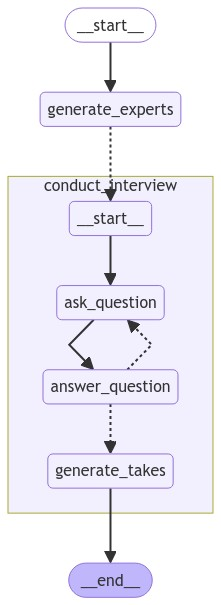

In [66]:
import sqlite3

from langgraph.constants import Send
from langgraph.checkpoint.sqlite import SqliteSaver

def initiate_all_interviews(state: OverallState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    topic = state["topic"]
    return [Send("conduct_interview", {"topic": topic,
                                       "expert": expert}) for expert in state["experts"]]

# Add nodes and edges 
overall_builder = StateGraph(OverallState)

# Add nodes and edges 
overall_builder.add_node("generate_experts", generate_experts)
overall_builder.add_node("conduct_interview", interview_builder.compile())

overall_builder.add_edge(START, "generate_experts")
overall_builder.add_conditional_edges("generate_experts", initiate_all_interviews, ["conduct_interview"])
overall_builder.add_edge("conduct_interview", END)

# Memory
db_path = "state_db/final_assistant.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

# Compile
graph = overall_builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Now, let's try running.

In [67]:
thread = {"configurable": {"thread_id": "3"}}
topic = "A strategy for top players to draft in Fantasy Football."
result = graph.invoke({"topic": topic}, thread)

CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.


In [68]:
from IPython.display import Markdown, display
for t in result['takes']:
    for take in t.takes:
        display(Markdown(f"### {take.title}\n{take.take}\n"))

### Get 'Your Guys' Over ADP
Prioritize drafting players you believe in over strictly adhering to Average Draft Position (ADP). If you want Cooper Kupp and he's not likely to be available in the fourth round, take him in the third round over players like Mike Evans or Nico Collins.


### Reaching Isn't Always Bad
If you want a player and he won’t be there next time you pick, it’s not a reach. Trust your research and instincts over ADP, especially in the middle rounds where player performance can vary significantly.


### Early Consistency, Late Upside
Draft consistent performers with a high floor early to build a stable foundation. Target high-upside players in the later rounds who might have more risk but also the potential to be league-winners.


### Metrics for Consistency and Upside
For consistency, look at past performance, target share, and role in the offense. For upside, consider athleticism, opportunity for increased workload, and changes in the team's offensive scheme.


### Late-Round Lottery Tickets
In the later rounds, target high-upside players and handcuffs. Look for players in high-powered offenses or those with a clear path to increased playing time, like rookies or second-year players who could break out.


### Adjust for League Format
In PPR leagues, prioritize wide receivers and pass-catching running backs. In standard scoring leagues, focus on players who can accumulate yardage and touchdowns, like workhorse running backs.


### Deebo Samuel: The Fifth-Round Steal
Deebo Samuel is a great example of value-based drafting. His ADP hovers around WR20, but his potential output makes him a steal in the fifth round.


### Jake Ferguson: Late-Round TE Gem
While top-tier TEs like Mark Andrews are great, targeting a TE like Jake Ferguson later in the draft can provide good value without sacrificing depth at other positions.


### Beware the Hype: Chris Olave Edition
Chris Olave has an ADP of WR9 despite finishing as WR19 last season. Unless there's overwhelming evidence of a breakout, it's better to avoid such players at their current price.


### Kenneth Walker: The Overlooked Game-Changer
Kenneth Walker is often overlooked because of the ADP of other running backs going ahead of him. However, with the Seahawks likely to increase their pace of play, he could outperform many of the RBs drafted before him.


### Balancing Act: Immediate Impact vs. Long-Term Potential
Draft a solid RB1 early for consistent points, then take a flyer on a high-upside rookie WR later to balance immediate impact and long-term potential.


### Deebo and Walker: The Winning Combo
Targeting undervalued players like Deebo Samuel and Kenneth Walker can secure high-performing players at a lower cost, allowing for a more balanced and competitive roster.


### Overvaluing Recent Performance: A Common Pitfall
Players often get drafted higher based on a few standout games from the previous season. It's important to look at the overall body of work and the context of those performances.


### Spread Out Those Bye Weeks!
Having too many key players on the same bye week can hurt your team. Spread out your bye weeks to avoid a single week where you're significantly weakened.


### Flexibility is Key: Adapt to the Draft
Sticking rigidly to a pre-draft plan can be detrimental. Be flexible and adapt based on how the draft unfolds.


### Stay Updated: Your Secret Weapon
Staying updated with the latest news and trends is crucial. Resources like ESPN, FantasyPros, and The Fantasy Footballers podcast provide valuable insights and updates.


### Reach for Your Guys!
Top Fantasy Football players prioritize drafting players they believe in, even if it means taking them earlier than their Average Draft Position (ADP) suggests. Trust your research and instincts over consensus ADP.


### Achane: The Late-Round Sleeper
Last season, savvy players who reached for Achane as a late-round sleeper were rewarded. This example highlights the importance of trusting your research and instincts.


### Balancing High-Upside vs. Consistent Performers
Top players balance high-upside picks and consistent performers by focusing on players they believe in, regardless of ADP. They take risks, especially in later rounds, where the potential reward outweighs the risk.


### High-Upside vs. Consistent Performers: Achane and Kupp
Achane was a high-upside pick who could break out, while Cooper Kupp was a consistent performer. Both types of players are crucial for a balanced Fantasy team.


### Early Rounds vs. Later Rounds Strategy
In early rounds, top players secure high-floor, high-ceiling players for consistency. In later rounds, they swing for the fences with high-upside picks and sleepers, ensuring a balanced team.


### Cooper Kupp: Early-Round Steal
Cooper Kupp, taken in the third round, provided first-round value, showcasing the importance of securing reliable performers early in the draft.


### Achane: Late-Round Gem
Achane, identified as a potential breakout player, delivered on his promise, proving the value of targeting high-upside sleepers in the later rounds.


### Handling Injuries and Bye Weeks
Top players draft depth and remain flexible to handle injuries and bye weeks. They understand that many later-round picks are on thin ice and are prepared to make adjustments.


### High-Risk, High-Reward: Diggs vs. Elliott
Stefon Diggs, undervalued due to concerns about Josh Allen, paid off as a high-risk pick. Conversely, Ezekiel Elliott, drafted too early based on past performance, didn't meet expectations.


### Stay Updated, Stay Ahead
Staying updated with the latest news and trends is crucial. It allows top players to make informed decisions and adjust their picks based on the most current information, ensuring a successful Fantasy season.


### Preparation is Key
Top Fantasy Football players differentiate themselves through meticulous preparation, studying player stats, team dynamics, and staying updated on training camp reports and injuries. This allows them to make informed decisions and adapt their strategies as the draft unfolds.


### First Few Rounds Strategy
In the first few rounds, top players focus on securing high-upside, high-floor players. For example, they might draft a top-tier running back like Saquon Barkley in Round 1, a high-performing wide receiver like Cooper Kupp in Round 2, and another reliable player in Round 3.


### Balancing Needs vs. Best Player Available
Top players strike a balance between drafting for positional needs and selecting the best player available. They fill key positions with high-quality players but pivot to BPA if a highly valuable player falls to them, ensuring they don't miss out on potential league-winners.


### Prioritizing Less Popular Positions
Top players might prioritize less popular positions early, such as drafting a tight end like Mark Andrews or a quarterback like Patrick Mahomes in the third or fourth round. This can provide a positional advantage that outweighs the depth available at other positions later.


### Middle Rounds Value Picks
In the middle rounds, top players look for value picks and potential breakout candidates. They might target players like Kenneth Walker, who has an established role and is expected to perform well based on training camp reports and team dynamics.


### Late Rounds High-Upside Fliers
In the later rounds, top players focus on high-upside fliers and depth. They might draft players like Jake Ferguson, who has a clear path to targets, or take a chance on rookies and second-year players who could break out.


### Essential Tools and Resources
Top players rely on tools like Fantasy Football Draft Kits, mock drafts, training camp reports, and advanced statistics. These resources help them make informed decisions and stay ahead of the competition.


### Preparation is Key
Top players spend significant time analyzing player statistics, team dynamics, and injury reports. For example, knowing that Lions RB Jahmyr Gibbs is recovering well from a leg injury can influence his draft value positively.


### Flexibility Wins Drafts
Top players have a preferred plan but are ready to adapt based on the draft's progression. For instance, if a high-value wide receiver like A.J. Brown is available later than expected, they might pivot from their initial running back focus.


### Value Picks are Gold
Identifying undervalued players is crucial. Top players might draft rookies or players returning from injury with high upside, like Malik Nabers, even if there are concerns about their team's offensive capabilities.


### Reading the Room
Top players adjust their strategy based on other managers' picks. If there's a run on running backs, they might focus on securing top wide receivers and tight ends, knowing they can find value running backs later.


### Balancing Risk and Reward
Top players make informed decisions by balancing risk and reward. For example, they might draft a player like A.J. Brown over Jahmyr Gibbs if they perceive a higher immediate value and lower risk.


### Staying Updated
Top players stay updated on the latest news and trends, such as injury reports and contract disputes, to make informed draft decisions. This ongoing research sets them apart from average players.


### Thorough Research
Top players' draft strategies are backed by thorough research. They analyze player statistics, team dynamics, and stay informed about the latest news, giving them an edge in making informed decisions.


### Adapting to Draft Dynamics
Top players are skilled at adapting to the draft dynamics. They constantly evaluate the draft landscape and are willing to deviate from their initial plan to maximize their team's potential.


We can look at the trace! 

https://smith.langchain.com/public/a0ddbec6-c3ae-45b8-b341-fc9a6247a994/r